# Structural Breaks

Another challenges related to time series analysis and causal inference, besides the presence of lagged effects, is the possibility of the system to be in **multiple states or regimes**. This is a problem well known to economists, since financial data often exhibits distinct behaviour depending on the specific state of the system (e.g., growth or recession).

In electricity markets, we can also witness something similar. In particular, in the **balancing market**, the system is constantly switching between two states {cite}`bunn2020analysis`.:
- **Short**, when there is a shortage of energy.
- **Long**, when there is an excess of energy.

Here, we will just provide an example of the challenges of trying to infer the causal structure of the system, if there is a **concept drift** affecting the system. In this case, we refer to concept drift as an alteration of the data-generating process, where the coefficients relating different variables change over time. For example:
- A **market policy** might significantly affect the behaviour or market partecipants.
- Newly introduced **subsidies** might alter the cost structures of energy generators.
- Advances in **battery technology** might introduce new variables.

## Scenario with Two Regimes

Let's consider a scenario in the electricity market where three variables are impacted by a significant **policy change**, such as the introduction of a new subsidy for renewable energy. This policy change affects the relationships among these variables, illustrating how concept drift can occur in response to external changes.

### Regime 1: Pre-Subsidy
Before the introduction of subsidies, the causal relationships might be modeled as follows:

\begin{equation}
    \mathbf{x}(t) = \mathbf{B}_{\text{pre}} \mathbf{x}(t-1) + \mathbf{e}(t)
\end{equation}

where $\mathbf{B}_{\text{pre}}$ is:

\begin{equation}
    \mathbf{B}_{\text{pre}} = 
    \begin{bmatrix}
    0 & 0 & 0 \\
    2 & 0 & 0 \\
    -1 & 0.05 & 0
    \end{bmatrix}
\end{equation}

The contemporaneous effects of regime 1 are represented by the following DAG:

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


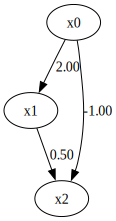

In [1]:
from lingam.utils import make_dot

B0_regime1 = [[0.0, 0.0, 0.0],
              [2.0, 0.0, 0.0],
              [-1.0, 0.5,0.0]]

make_dot(B0_regime1)

### Regime 2: Post-Subsidy
After the introduction of subsidies, the relationships change as follows:

\begin{equation}
\mathbf{x}(t) = \mathbf{B}_{\text{post}} \mathbf{x}(t-1) + \mathbf{e}(t)
\end{equation}

where $\mathbf{B}_{\text{post}}$ is:

\begin{equation}
    \mathbf{B}_{\text{post}} = 
    \begin{bmatrix}
    0 & 0 & 0 \\
    -1 & 0 & 0 \\
    5 & 0 & 0
    \end{bmatrix}
\end{equation}

This change in coefficients represents a concept drift, where the underlying data-generating process has altered due to external policy intervention. The challenge in causal inference here is to accurately detect and adapt to these changes, ensuring that models remain valid over time despite the evolving relationships. Failure to account for such drifts can lead to inaccurate predictions and misguided policy or business decisions.

The contemporaneous effects of regime 2 are represented by the following DAG:

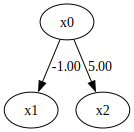

In [2]:
B0_regime2 = [[0.0, 0.0, 0.0],
              [-1.0, 0.0, 0.0],
              [5.0, 0.0,0.0]]

make_dot(B0_regime2)

(You might have now recognised this as a simple **fork**)

### Lagged Effects

To slightly render the causal discovery problem more difficult, we also introduced some autocorrelation, just like in the **VARLiNGAM** example we saw in the previous chapter.

This simply means we now also have two $\mathbf{B}_1$ matrices, one for each regime.

In [3]:
B1_regime1 = [[0.7, 0.0, 0.0],
              [0.2, -0.6, 0.0],
              [0.1, 0.0,0.1]]

B1_regime2 = [[0.0, 0.0, 0.0],
              [0.2, 0.2, 0.0],
              [0.5, 0.0,0.1]]

causal_order = [0, 1, 2]

We now **generate some observations** using this four matrices

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Sample size
np.random.seed(0)
n_features = len(causal_order)
sample_size = 500
switch_point = 250  # Midpoint switch

# Coefficients for two different regimes
B0_regime1 = np.array(B0_regime1)
B0_regime2 = np.array(B0_regime2)
B1_regime1 = np.array(B1_regime1)
B1_regime2 = np.array(B1_regime2)

# Initialize the data matrix with zeros (considering t and t-1)
data = np.zeros((sample_size + 1, n_features))  # +1 to accommodate initial values at t=-1

# Data matrix to accommodate initial values at t=-1
for i in range(n_features):
    data[:, i] += np.random.uniform(size=sample_size + 1)

# Generate data according to VARLiNGAM model with switching regimes
for t in range(1, sample_size + 1):
    if t < switch_point:
        for var in causal_order:
            data[t, var] += np.dot(B0_regime1[var, :], data[t, :]) + np.dot(B1_regime1[var, :], data[t-1, :])
    else:
        for var in causal_order:
            data[t, var] += np.dot(B0_regime2[var, :], data[t, :]) + np.dot(B1_regime2[var, :], data[t-1, :])

# Drop the initial row used for t=-1 values
data = data[1:, :]

# Convert to DataFrame for easier handling
X = pd.DataFrame(data, columns=[f"x{i}" for i in range(n_features)])

Let's now plot the data to see what is happening

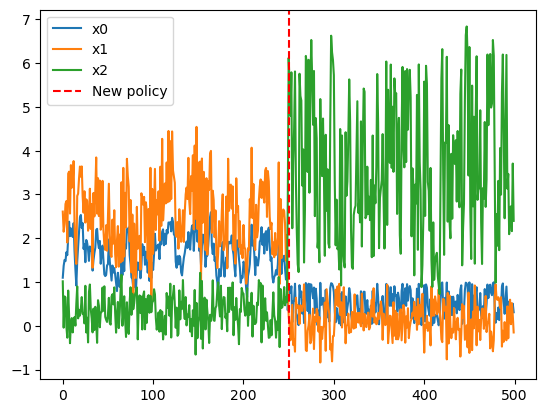

In [5]:
for i in range(X.shape[1]):
    plt.plot(X.index, X.iloc[:, i], label=f'x{i}')
plt.axvline(x=switch_point, color='r', linestyle='--', label='New policy')
plt.legend()

We can clearly see how the introduction of the new policy altered the time series.


## Estimation

To show the difficulty of doing causal discovery using data collected from drifting data streams, we will show what happens in two cases:
1. We fit just one model to the whole dataset.
2. We fit two separate models, one for each regime.

### Fitting One Model

As we did before, we fit a VAR model, compute the residuals, and apply LiNGAM to its residuals.

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


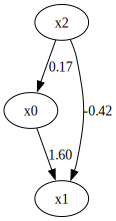

In [6]:
from statsmodels.tsa.vector_ar.var_model import VAR
import lingam

# Fit one VAR model
var_model = VAR(X)
var_results = var_model.fit(1)
residuals = var_results.resid

# Apply LiNGAM to the residuals
lingam_model = lingam.DirectLiNGAM()
lingam_model.fit(residuals)
make_dot(lingam_model.adjacency_matrix_)  # B0

We can see how we got a **wrong estimation**. The causal structure is like the first regime, but the coefficients are wrong.

### Fitting Two Models

We now show the ideal situation, where we assume we were able to **discern the two regimes** and fit distinct models.

In [7]:
# Split the data into two regimes
x_regime1 = X.iloc[:switch_point, :]
x_regime2 = X.iloc[switch_point:, :]

# Fit VAR model to each regime
var_model1 = VAR(x_regime1)
var_results1 = var_model1.fit(1)  # VAR(1) for simplicity
residuals_regime1 = var_results1.resid

var_model2 = VAR(x_regime2)
var_results2 = var_model2.fit(1)  # VAR(1) for simplicity
residuals_regime2 = var_results2.resid

# Apply LiNGAM for each regime
lingam_model1 = lingam.DirectLiNGAM()
lingam_model1.fit(residuals_regime1)

lingam_model2 = lingam.DirectLiNGAM()
lingam_model2.fit(residuals_regime2)

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


For the first regime, we now have

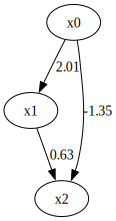

In [8]:
make_dot(lingam_model1.adjacency_matrix_)  # B0 regime 1

and for the second regime

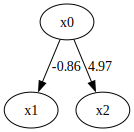

In [9]:
make_dot(lingam_model2.adjacency_matrix_) # B0 regime 2

We can clearly see how, taking into account the **policy change** we have been able to identify the **true causal structures**.